# Bitcoin Price Prediction Using Twitter Sentimental Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import mplfinance as mpf
import seaborn as sns
from dateutil import parser

## Bitcoin Price Analysis

In [3]:
btc_data = pd.read_csv("crytpo_data.csv", index_col = 0)
btc_data.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,timestamp,time
_id,,,,,,,,,,
67477c998ad02b4e72f11b46,BTC,Bitcoin USD,96921.72,96962.00,91804.37,8.124583e+10,91938.32,91938.32,1732738201,2024-11-27 20:10:01.889000
67476e8a722b15343d0157f4,BTC,Bitcoin USD,96078.15,96664.20,91804.37,8.124583e+10,91938.32,91938.32,1732734600,2024-11-27 19:10:02.207000
6747607add19519ca50317d8,BTC,Bitcoin USD,96328.41,96530.48,91804.37,8.124583e+10,91938.32,91938.32,1732731000,2024-11-27 18:10:02.034000


In [4]:
btc_data.describe()

,price,dayHigh,dayLow,volume,open,close,timestamp
count,729.000000,729.000000,729.000000,7.290000e+02,729.000000,729.000000,7.290000e+02
mean,83536.379849,84597.927016,81695.471811,7.108863e+10,82767.179084,82767.179084,1.731428e+09
std,10787.795406,10954.365599,10609.820189,3.269491e+10,10831.622600,10831.622600,7.579677e+05
min,67403.940000,68538.000000,66783.770000,1.819931e+10,67785.195000,67785.195000,1.730132e+09
25%,72306.000000,72714.380000,69705.760000,4.551983e+10,70202.875000,70202.875000,1.730773e+09
50%,87671.530000,89600.000000,85010.000000,6.365704e+10,87305.710000,87305.710000,1.731428e+09
75%,92476.100000,93772.260000,90853.000000,8.930853e+10,91938.320000,91938.320000,1.732083e+09
max,99639.100000,99860.000000,97806.000000,1.698264e+11,99005.305000,99005.305000,1.732738e+09


In [5]:
# Drop rows with missing values
btc_data = btc_data.dropna()

# Convert the 'timestamp' column to datetime and set it as the index
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'], unit='s')
btc_data = btc_data.set_index('timestamp').sort_index()  # Sort by timestamp in ascending order

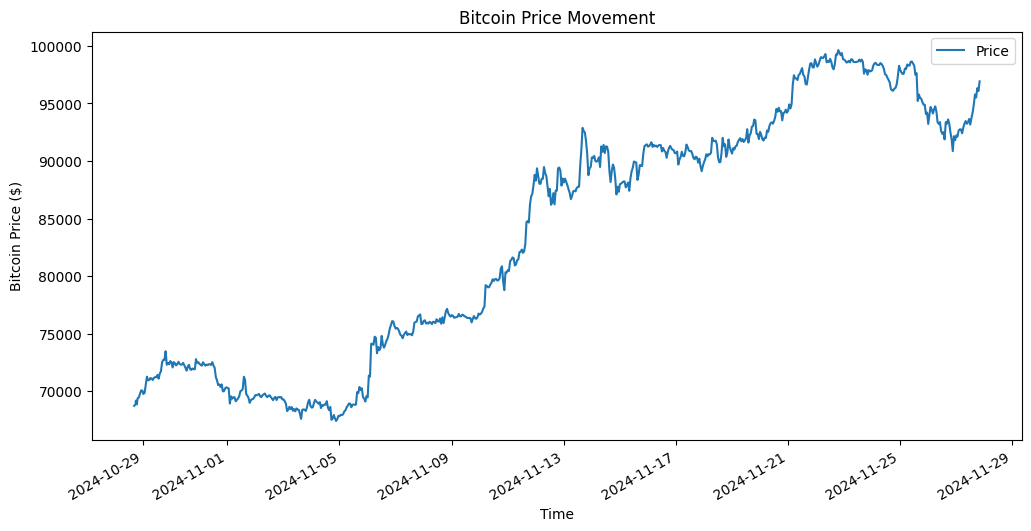

In [6]:
# Plot the Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["price"], label="Price")
plt.xlabel('Time')
plt.ylabel('Bitcoin Price ($)')
plt.title('Bitcoin Price Movement')
plt.legend()

# Automatically format the x-axis
plt.gcf().autofmt_xdate()
plt.show()

### Time Series Analysis

In [7]:
import util.plot as p

In [8]:
# Resample to 6-hour intervals
daily_data = btc_data.resample('6H').agg({
    'open': 'first',
    'price': 'last',
    'dayHigh': 'max',
    'dayLow': 'min',
    'volume': 'sum'
})

# Clean and rename columns for mplfinance
daily_data = daily_data.fillna(method='ffill').dropna()
daily_data = daily_data.rename(columns={
    'price': 'Close',
    'dayHigh': 'High',
    'dayLow': 'Low',
    'open': 'Open',
    'volume': 'Volume'
})

daily_data.head(3)

/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/517740996.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_data = btc_data.resample('6H').agg({
/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/517740996.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data = daily_data.fillna(method='ffill').dropna()


,Open,Close,High,Low,Volume
timestamp,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11


In [52]:
# Add moving averages
daily_data['SMA5'] = daily_data['Close'].rolling(window=5, min_periods=1).mean()
daily_data['SMA10'] = daily_data['Close'].rolling(window=10, min_periods=1).mean()

daily_data.head(3)

,Open,Close,High,Low,Volume,SMA5,SMA10,rtn
timestamp,,,,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11,69151.610000,69151.610000,NaN
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11,69601.305000,69601.305000,0.013006
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11,70055.963333,70055.963333,0.013052


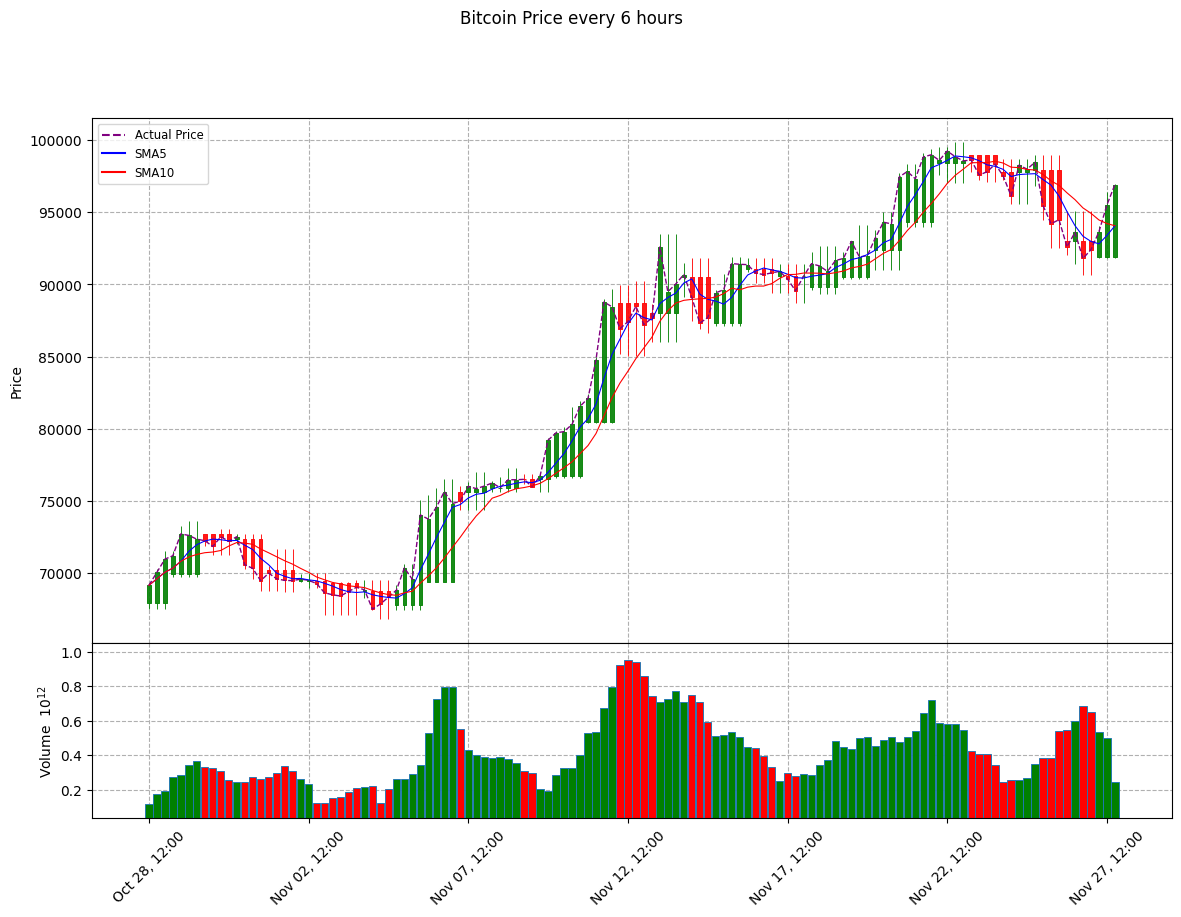

In [10]:
# Create candlestick chart
fig_candle, _ = p.plot_candlestick(daily_data)
plt.show()

### Return outlier Analysis

In [11]:
import util.analysis as a

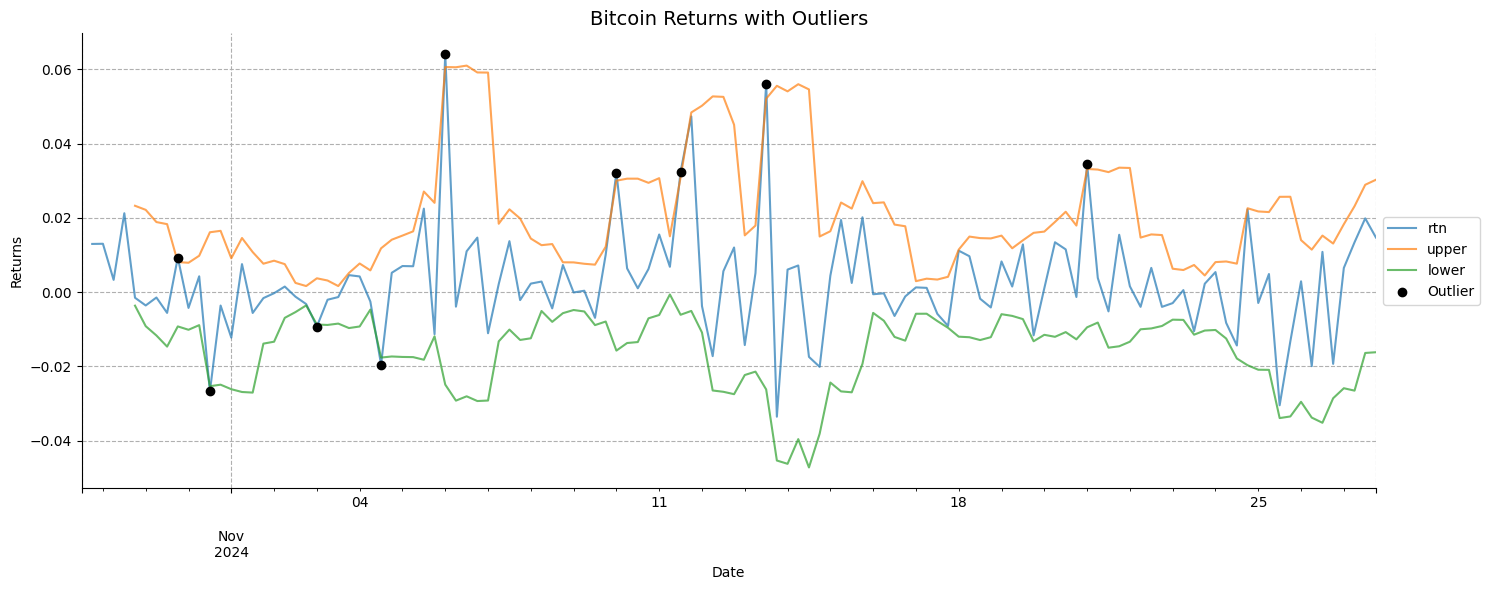

In [12]:
# Analyze returns
returns_analysis = a.analyze_returns(daily_data)
fig_returns, _ = p.plot_returns(returns_analysis)
plt.show()

### Technical Indicator Analysis

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/analysis.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RSI'].fillna(50, inplace=True)  # Fill initial NaN values


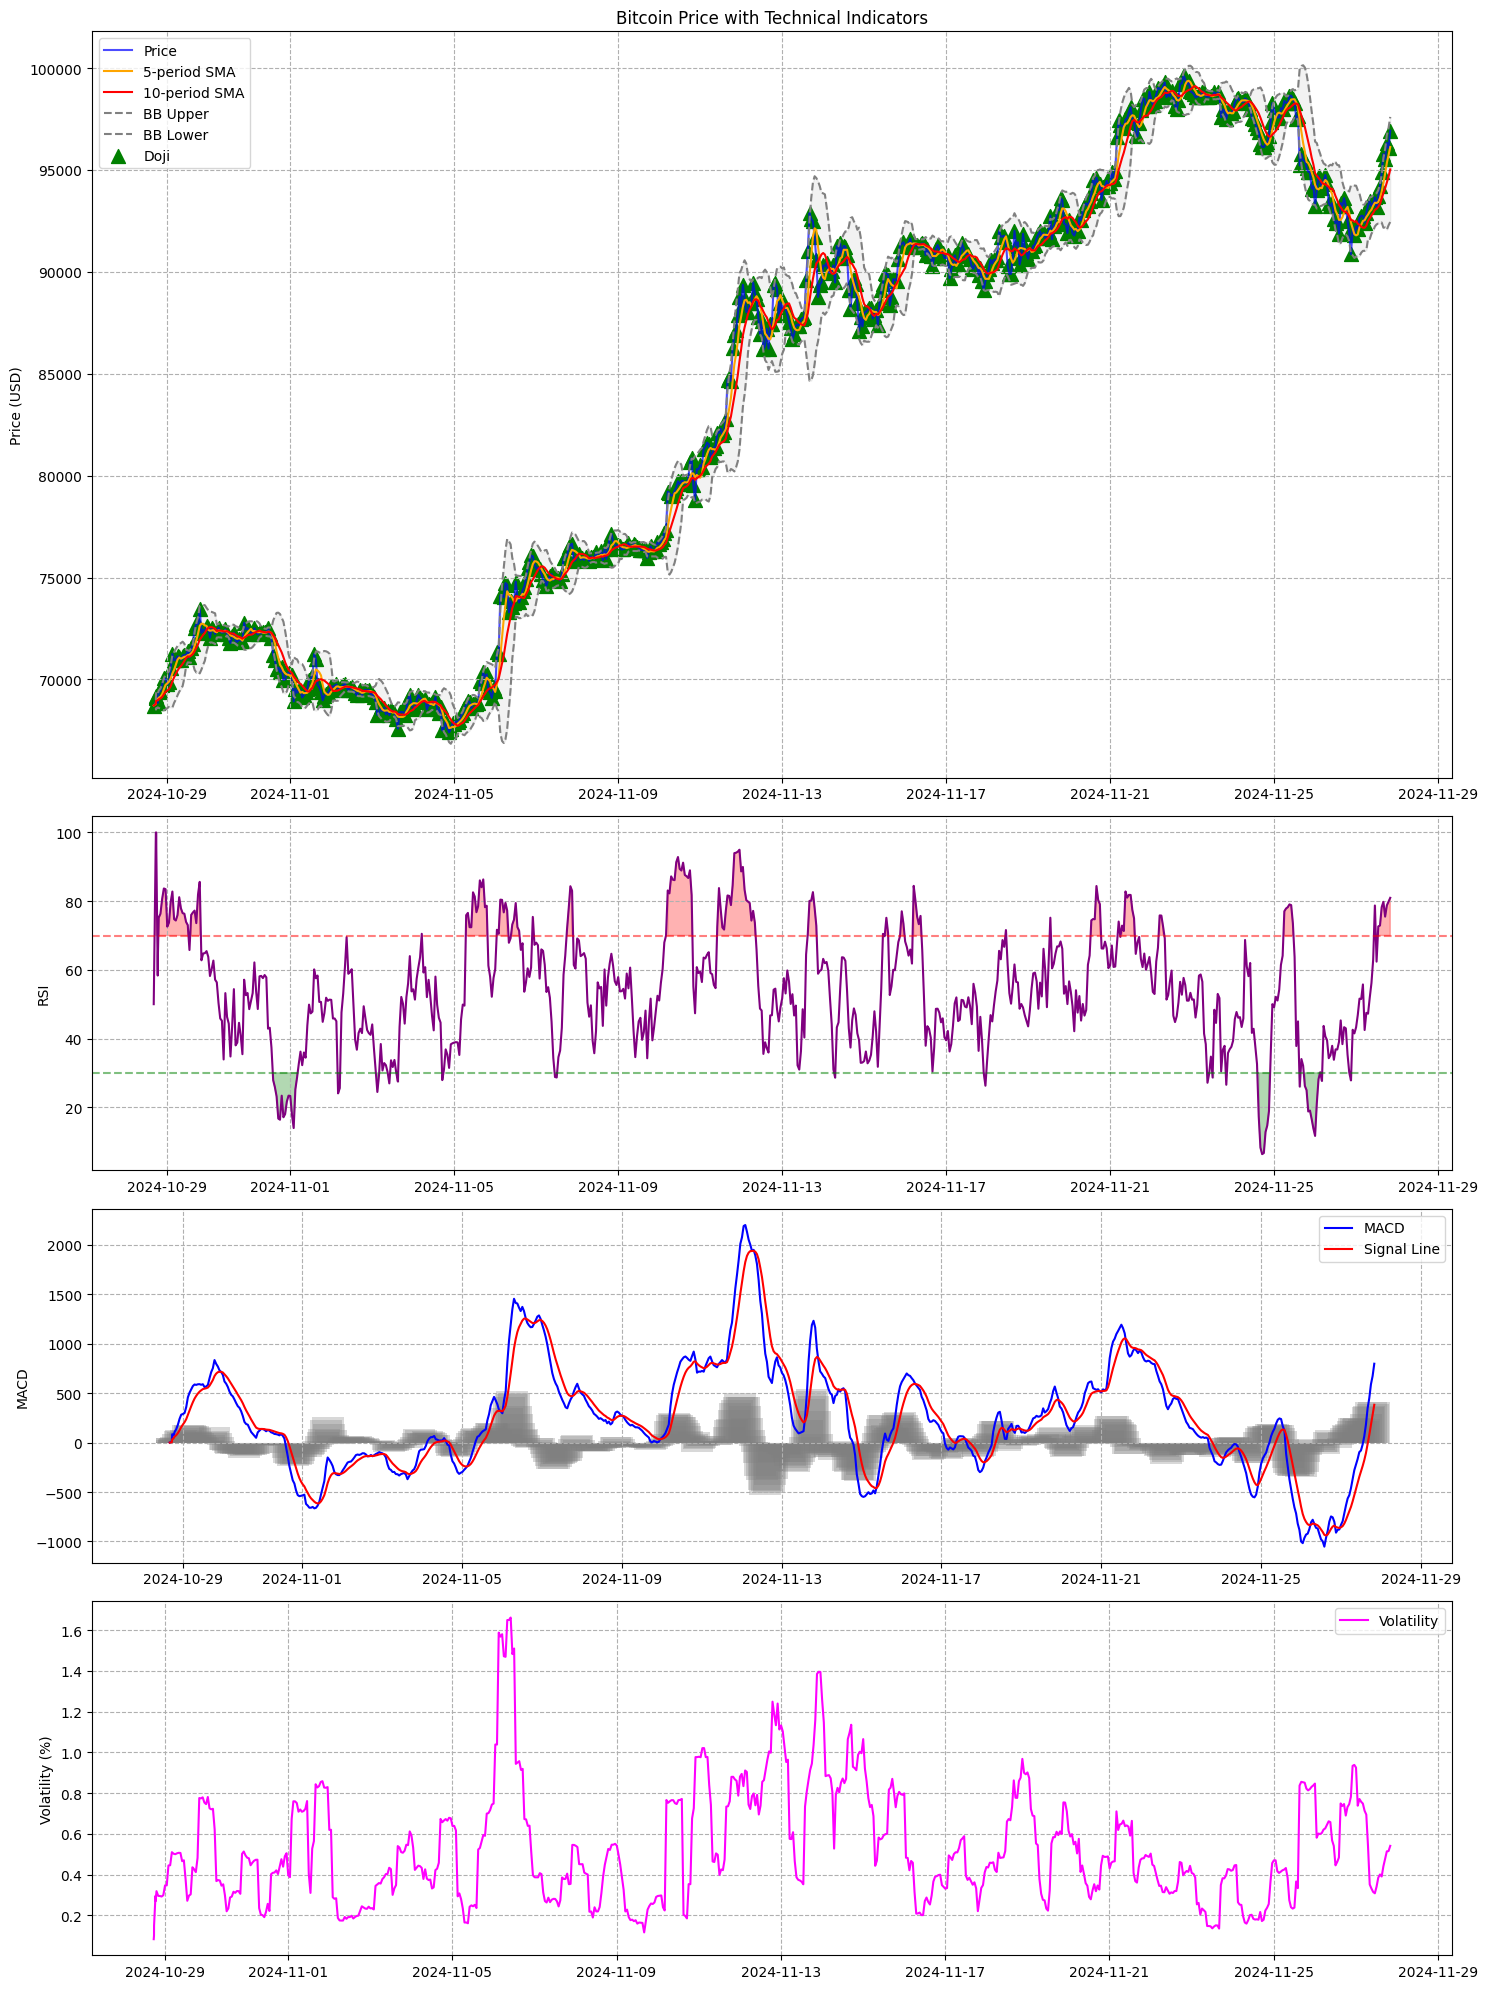

In [13]:
# Example usage
df_with_indicators = a.calculate_technical_indicators(btc_data)

# If you want pattern detection (only if you have OHLC data):
if all(col in btc_data.columns for col in ['open', 'close', 'dayHigh', 'dayLow']):
    df_with_indicators = a.detect_patterns(df_with_indicators)
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=True)
else:
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=False)

plt.show()

In [56]:
btc_data = df_with_indicators 
df_with_indicators.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,BB_middle,BB_upper,BB_lower,RSI,MACD,Signal_Line,MACD_Histogram,volatility,Doji,Hammer
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-28 16:14:23,BTC,Bitcoin USD,68720.00,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 16:14:24.819000,68720.00,...,68720.00,NaN,NaN,50.0,0.000000,0.000000,0.000000,NaN,True,False
2024-10-28 17:29:02,BTC,Bitcoin USD,68862.88,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:29:04.644000,68791.44,...,68791.44,68993.502834,68589.377166,100.0,11.397835,2.279567,9.118268,NaN,True,False
2024-10-28 17:33:29,BTC,Bitcoin USD,69086.55,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:33:29.737000,68889.81,...,68889.81,69259.315855,68520.304145,100.0,38.040494,9.431752,28.608741,0.082653,True,False


## II Twitter Sentimental Analysis

In [104]:
tw_data = pd.read_csv('twitter_data.csv',index_col=0)
tw_data.head(5)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time
_id,,,,,,,,,,,,,
671fe1125a22311369600909,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090a,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end \nof Octo...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090b,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090c,BTC,bitcoin,1849150584693076274,MarwanNawaz,6.0,458.0,Wed Oct 23 18:07:09 +0000 2024,"Michael Saylor would ""volunteer"" his Bitcoin t...",en,3.0,9.0,74.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090d,BTC,bitcoin,1848948161806798989,naiivememe,1779.0,10437.0,Wed Oct 23 04:42:48 +0000 2024,Me leaving my 9-5 job when Bitcoin hits 250K\n...,en,104.0,272.0,889.0,2024-10-28 19:08:02.786000


### Flair Sentiment Analysis
- Test out Flair using selected twitter sample.
- Reference: [Flair](https://github.com/flairNLP/flair)

In [105]:
from flair.data import Sentence
from flair.nn import Classifier

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)
sentence = Sentence(sample)

tagger = Classifier.load('sentiment')
tagger.predict(sentence)

print("Sentiment Value: ", sentence.labels[0].value)
print("Sentiment Confidence: ", sentence.labels[0].score)

Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Sentiment Value:  POSITIVE
Sentiment Confidence:  0.9328526854515076


## VADER Sentiment Analysis
- Test out VADER using selected Twitter sample.
- Reference: [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment)

In [106]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)

analyzer = SentimentIntensityAnalyzer()

vs = analyzer.polarity_scores(sample)
print("{:-<65} {}".format(sample, str(vs)))

Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.5106}


### Data Preprocessing
- Extract link values from the **text** column with regex.
- Remove all "\n" from the **text** column.
- Assert if there is any missing value for the **text** column.
- Assert if there is any empty string for the **text** column.

In [107]:
import re
import util.text as t

In [108]:
# Assert if there is any missing values for the **text** column
# assert tw_data.isnull().sum()['text'] == 0

In [109]:
# If there is missing values, drop these missing values
tw_data = tw_data.dropna()

In [110]:
# Extract link values from the **text** column with regex.
tw_data['text'] = tw_data['text'].apply(
  lambda x: re.sub(r'https?://\S+', '', x).strip()
  )  
# Remove all "\n" from the **text** column.
tw_data['text'] = tw_data['text'].replace('\n', '', regex=True)

tw_data.iloc[1]['text']

'If Bitcoin breaks $72,000 by the end of October, I will give $2,000 BTC to 20 people who like this post.'

In [111]:
# Assert if there is any empty strings for the **text** column
# assert len(tw_data.index[tw_data['text'] == ''].tolist()) == 0

In [112]:
# Check empty string for the **text** colum
print("Number of empty strings: ", len(tw_data.index[tw_data['text'] == ''].tolist()))
tw_data.index[tw_data['text'] == ''].tolist()[:5]

Number of empty strings:  39


['6725c23c2ecab7f9c39b03c1',
 '6725fa7e69400ce2a905b5de',
 '6726952c7222003579d6c677',
 '6726a33c966067f276961a06',
 '6726bf5f062b2dc3b39b4ca1']

In [113]:
# Apply Flair sentiment anaylysis to the twitter dataset.
tw_data[['fl_sentiment', 'fl_confidence']] = tw_data['text'].apply(
  lambda x: pd.Series(t.flair_sentiment(x))
  )

tw_data['fl_sentiment'].head(1)
tw_data['fl_confidence'].head(1)

String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/3946928707.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.flair_sentiment(x))


_id
671fe1125a22311369600909    0.837528
Name: fl_confidence, dtype: float64

In [114]:
# Apply VADER sentiment anaylysis to the twitter dataset.
tw_data[['vd_negative', 'vd_neutral', 'vd_positive', 'vd_compound']] = tw_data['text'].apply(
  lambda x: pd.Series(t.vader_sentiment(x))
  )

tw_data.head(1)

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be

String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.
String is empty. No result.


/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(t.vader_sentiment(x))
/var/folders/hy/1bfvxh256v3638lr5009_v2c0000gn/T/ipykernel_78763/1512669879.py:3: FutureWarning: The default dtype for empty Series will be

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
_id,,,,,,,,,,,,,,,,,,,
671fe1125a22311369600909,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000,POSITIVE,0.837528,0.0,0.769,0.231,0.5106


In [115]:
# Convert current cleaned data to csv
tw_data.to_csv('updated_twitter_data.csv', index=False)

## Visualize Preprocessed Data

In [14]:
tw_data = pd.read_csv('updated_twitter_data.csv')
tw_data.describe()

,tweet_id,bookmarks,favorites,quotes,replies,retweets,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
count,1.207800e+04,12078.000000,12078.000000,12078.000000,12078.000000,12078.000000,12039.000000,12039.000000,12039.000000,12039.000000,12039.000000
mean,1.855260e+18,320.077745,6307.339129,67.245984,594.567395,1260.782083,0.948589,0.026164,0.880151,0.093680,0.192342
std,5.680791e+15,885.494704,11757.474182,223.043356,1895.199431,2832.791556,0.100787,0.077826,0.141223,0.127636,0.386998
min,1.722846e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.504756,0.000000,0.218000,0.000000,-0.945100
25%,1.852763e+18,19.000000,825.000000,5.000000,49.000000,136.000000,0.956594,0.000000,0.775000,0.000000,0.000000
50%,1.855918e+18,80.000000,2701.000000,18.000000,169.000000,426.000000,0.997250,0.000000,0.917000,0.000000,0.000000
75%,1.858449e+18,241.000000,7029.500000,49.000000,469.000000,1193.750000,0.999667,0.000000,1.000000,0.187000,0.492600
max,1.861854e+18,17293.000000,208292.000000,3902.000000,50094.000000,43987.000000,0.999997,0.705000,1.000000,0.782000,0.995400


### Visualize Flair Sentiment Movements

In [15]:
# Preprocess fl_confidence value by fl_sentiment column.
tw_data['fl_confidence'] = np.where(tw_data['fl_sentiment'] == 'NEGATIVE', 
                                 -tw_data['fl_confidence'], 
                                 tw_data['fl_confidence'])
tw_data.head(3)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
0,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000,POSITIVE,0.837528,0.0,0.769,0.231,0.5106
1,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end of Octobe...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786000,NEGATIVE,-0.999922,0.0,0.889,0.111,0.3612
2,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786000,NEGATIVE,-0.999045,0.0,0.839,0.161,0.3612


### 1. Visualize Mean and Median Values
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [16]:
tw_data['time'] = pd.to_datetime(tw_data['time'])

In [49]:
tw_data = tw_data.sort_values(by='time')

# Hourly mean
f_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].mean().reset_index()

f_hr_mean.head(3)

,time,fl_confidence
0,2024-10-28 19:00:00,-0.659364
1,2024-10-28 20:00:00,-0.856142
2,2024-10-28 21:00:00,-0.547036


In [50]:
# Hourly median
f_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].median().reset_index()

f_hr_med.head(3)

,time,fl_confidence
0,2024-10-28 19:00:00,-0.962878
1,2024-10-28 20:00:00,-0.992461
2,2024-10-28 21:00:00,-0.991899


In [121]:
# Hourly standard deviation
f_hr_std = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].std().reset_index()

f_hr_std.head()

,time,fl_confidence
0,2024-10-28 19:00:00,0.691188
1,2024-10-28 20:00:00,0.479230
2,2024-10-28 21:00:00,0.801825
3,2024-10-28 22:00:00,0.631571
4,2024-10-28 23:00:00,0.749526


/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/680544887.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


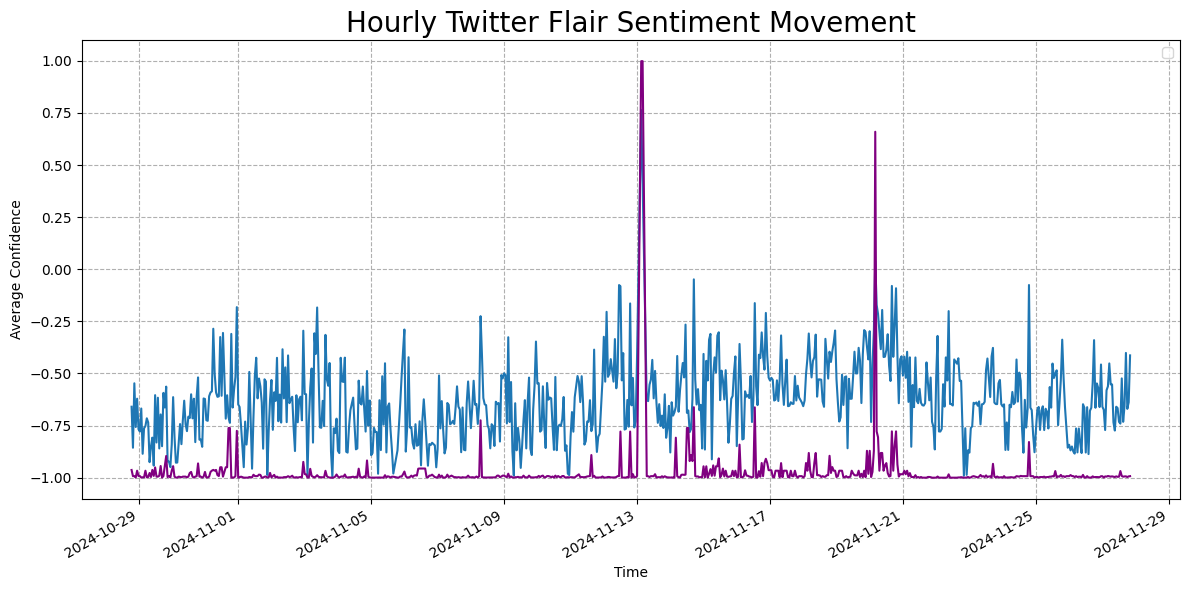

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(f_hr_mean['time'], f_hr_mean['fl_confidence'])
plt.plot(f_hr_med['time'], f_hr_med['fl_confidence'], color='purple')

plt.title('Hourly Twitter Flair Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [48]:
# Daily mean
f_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].mean().reset_index()

f_day_mean.head(3)

,time,fl_confidence
0,2024-10-28,-0.683241
1,2024-10-29,-0.777407
2,2024-10-30,-0.742708


In [47]:
# Daily median
f_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].median().reset_index()

f_day_med.head(3)

,time,fl_confidence
0,2024-10-28,-0.992180
1,2024-10-29,-0.994748
2,2024-10-30,-0.994748


/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/3937480033.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


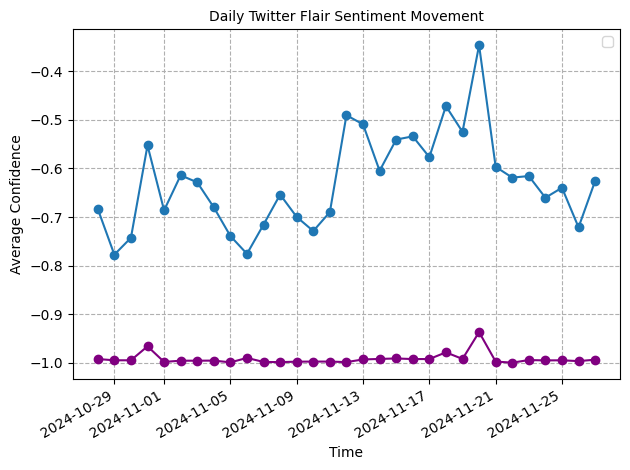

In [23]:
plt.figure()

plt.plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o')
plt.plot(f_day_med['time'], f_day_med['fl_confidence'], color='purple', marker='o')

plt.title('Daily Twitter Flair Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### 2. Visualize Sentiment Values
- For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
- Drop any empty data from **sentiment** column.

In [46]:
# For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
hr_pos_neg = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_sentiment'].value_counts().unstack().reset_index()

hr_pos_neg.head(3)

fl_sentiment,time,NEGATIVE,POSITIVE
0,2024-10-28 19:00:00,28.0,6.0
1,2024-10-28 20:00:00,16.0,1.0
2,2024-10-28 21:00:00,13.0,4.0


In [25]:
# Check if there is any empty data
hr_pos_neg.isnull().sum()

fl_sentiment
time         0
NEGATIVE     0
POSITIVE    24
dtype: int64

In [26]:
# Drop any empty data
hr_pos_neg = hr_pos_neg.dropna()[1:]

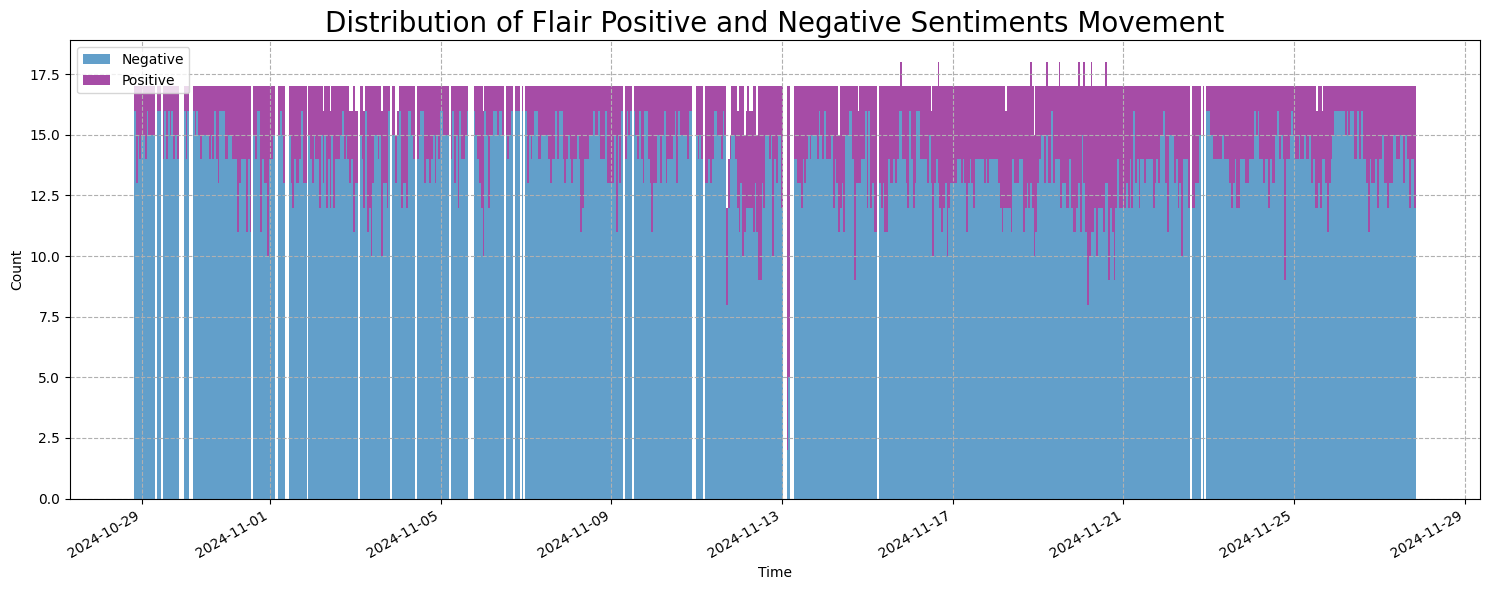

In [27]:
plt.figure(figsize=(15, 6))

plt.bar(hr_pos_neg['time'], hr_pos_neg['NEGATIVE'], width=1/24,
        alpha=0.7, label='Negative')

plt.bar(hr_pos_neg['time'], hr_pos_neg['POSITIVE'], width=1/24,
        bottom=hr_pos_neg['NEGATIVE'], color='purple', alpha=0.7, label='Positive')

plt.title('Distribution of Flair Positive and Negative Sentiments Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Visualize VADER Sentiment Movement
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [29]:
# Hourly mean
v_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_hr_mean.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.067324,0.039471,0.893147,0.090591
1,2024-10-28 20:00:00,0.055529,0.025824,0.918588,0.071700
2,2024-10-28 21:00:00,0.115412,0.000000,0.884588,0.287594


In [30]:
# Hourly median
v_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_hr_med.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.000,0.0,0.903,0.0000
1,2024-10-28 20:00:00,0.000,0.0,1.000,0.0000
2,2024-10-28 21:00:00,0.123,0.0,0.877,0.3182


/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/371765151.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


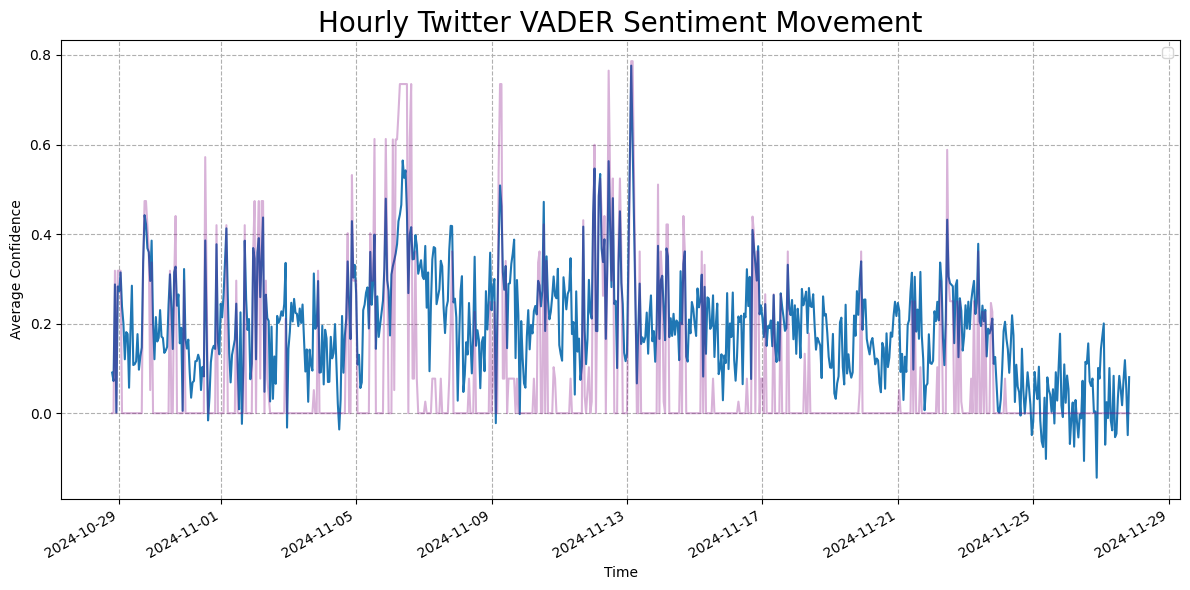

In [31]:
plt.figure(figsize=(12, 6))

plt.plot(v_hr_mean['time'], v_hr_mean['vd_compound'])
plt.plot(v_hr_med['time'], v_hr_med['vd_compound'], color='purple', alpha=0.3)

plt.title('Hourly Twitter VADER Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [44]:
# Daily mean
v_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_day_mean.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.084480,0.032990,0.882500,0.137509
1,2024-10-29,0.087436,0.020728,0.891824,0.229950
2,2024-10-30,0.078708,0.015728,0.905576,0.199071


In [45]:
# Daily median
v_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_day_med.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.0,0.0,0.889,0.0
1,2024-10-29,0.0,0.0,0.889,0.0
2,2024-10-30,0.0,0.0,1.000,0.0


/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/1387633730.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


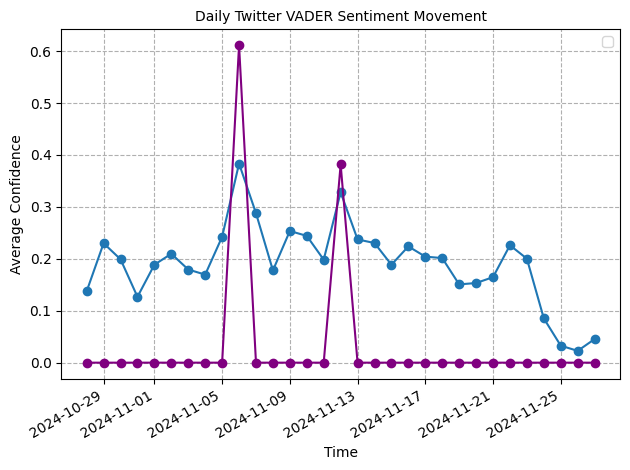

In [34]:
plt.figure()

plt.plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o')
plt.plot(v_day_med['time'], v_day_med['vd_compound'], color='purple',  marker='o')

plt.title('Daily Twitter VADER Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### Visualize both Sentiment Movements

/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_7815/862961805.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


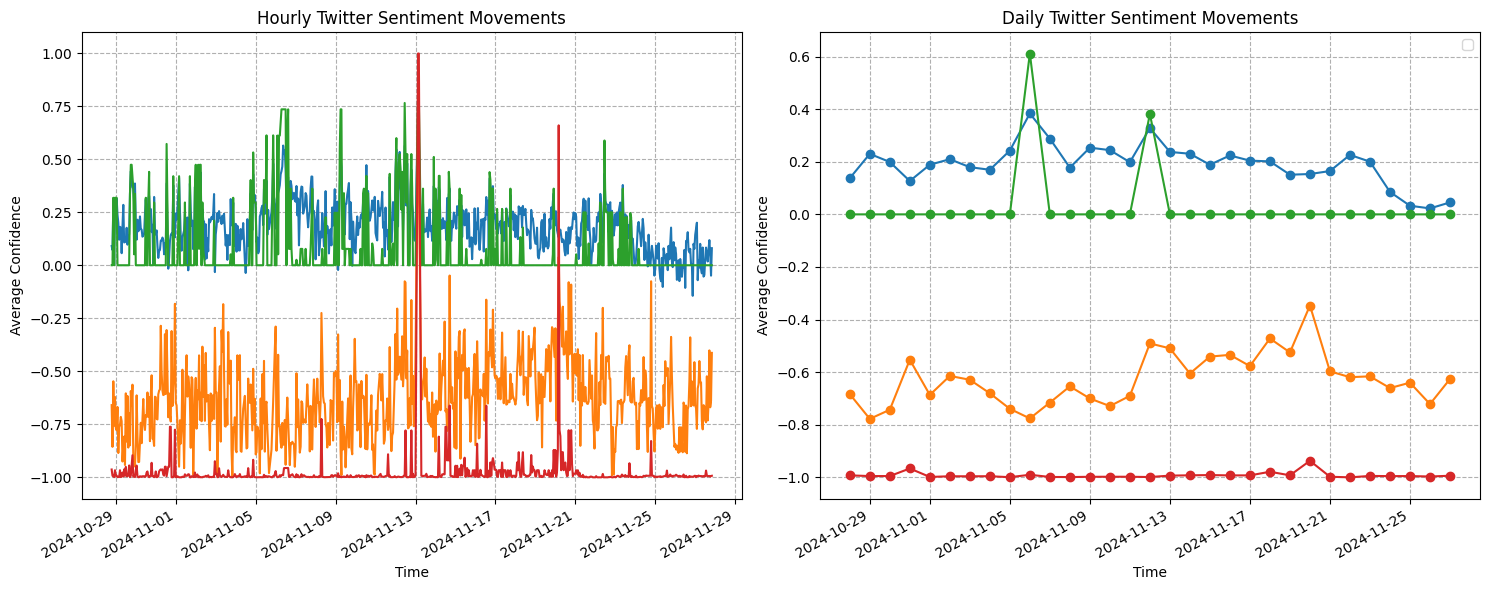

In [35]:
# Twitter sentiment movements through time
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(v_hr_mean['time'], v_hr_mean['vd_compound'])
ax[0].plot(f_hr_mean['time'], f_hr_mean['fl_confidence'])
ax[0].plot(v_hr_med['time'], v_hr_med['vd_compound'])
ax[0].plot(f_hr_med['time'], f_hr_med['fl_confidence'])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Average Confidence")
ax[0].set_title("Hourly Twitter Sentiment Movements")

ax[1].plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o')
ax[1].plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o')
ax[1].plot(v_day_med['time'], v_day_med['vd_compound'], marker='o')
ax[1].plot(f_day_med['time'], f_day_med['fl_confidence'], marker='o')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Average Confidence")
ax[1].set_title("Daily Twitter Sentiment Movements")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## Find Correlation between Bitcoin Price Movemnent VS. Twitter Sentiment

In [57]:
# Clean hourly BTC price data
hr_btc = btc_data
hr_btc['time'] = pd.to_datetime(hr_btc['time'], format="mixed")
hr_btc['time'] = hr_btc['time'].dt.floor('h')
  
hr_btc.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,BB_middle,BB_upper,BB_lower,RSI,MACD,Signal_Line,MACD_Histogram,volatility,Doji,Hammer
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-28 16:14:23,BTC,Bitcoin USD,68720.00,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 16:00:00,68720.00,...,68720.00,NaN,NaN,50.0,0.000000,0.000000,0.000000,NaN,True,False
2024-10-28 17:29:02,BTC,Bitcoin USD,68862.88,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,68791.44,...,68791.44,68993.502834,68589.377166,100.0,11.397835,2.279567,9.118268,NaN,True,False
2024-10-28 17:33:29,BTC,Bitcoin USD,69086.55,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,68889.81,...,68889.81,69259.315855,68520.304145,100.0,38.040494,9.431752,28.608741,0.082653,True,False


In [58]:
hr_btc.to_csv('hourly_btc_tw_data.csv')

In [60]:
# Load the hourly dataset
btc_data = pd.read_csv('hourly_btc_tw_data.csv')

# Convert 'time' to datetime
btc_data['time'] = pd.to_datetime(btc_data['time'])

In [ ]:
# Resample to daily intervals and calculate required metrics
day_btc = btc_data.resample('D', on='time').agg({
    'price': ['first', 'last', 'mean'],  # Open, Close, and Average Price
    'volume': 'sum',                     # Total Volume
    'dayHigh': 'max',                    # Daily High Price
    'dayLow': 'min',                     # Daily Low Price
    'SMA_5': 'mean',                     # Average SMA_5
    'SMA_10': 'mean',                    # Average SMA_10
    'RSI': 'mean',                       # Average RSI
    'MACD': 'last',                      # Last MACD Value of the Day
    'Signal_Line': 'last',               # Last Signal Line of the Day
    'MACD_Histogram': 'last'             # Last MACD Histogram of the Day
}).reset_index()

# Fix for multi-level columns
day_btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in day_btc.columns]

# Reformat column names
day_btc = day_btc.rename(columns={
    'time_': 'time',
    'price_first': 'open',
    'price_last': 'close',
    'price_mean': 'price',
    'volume_sum': 'volume',
    'dayHigh_max': 'dayHigh',
    'dayLow_min': 'dayLow',
    'SMA_5_mean': 'SMA_5',
    'SMA_10_mean': 'SMA_10',
    'RSI_mean': 'RSI',
    'MACD_last': 'MACD',
    'Signal_Line_last': 'Signal_Line',
    'MACD_Histogram_last': 'MACD_Histogram'
})

# Display the first few rows of the resampled daily data
print("\nFirst few rows:")
print(day_btc.head())

# Check the data types and missing values
print("\nDataset Info:")
print(day_btc.info())

print("\nMissing Values:")
print(day_btc.isnull().sum())

# Save the daily data to a CSV file
day_btc.to_csv('day_btc_data.csv', index=False)


First few rows:
        time      open     close         price        volume   dayHigh  \
0 2024-10-28  68720.00  70051.00  69289.377500  2.938971e+11  70288.00   
1 2024-10-29  69752.42  72607.98  71537.300417  1.092847e+12  73624.98   
2 2024-10-30  72508.29  72515.00  72240.830417  1.336778e+12  73624.98   
3 2024-10-31  72364.69  70327.64  71540.485417  1.027684e+12  73060.00   
4 2024-11-01  70279.98  69493.18  69668.325833  1.174492e+12  72684.02   

     dayLow         SMA_5        SMA_10        RSI        MACD  Signal_Line  \
0  67532.48  69101.052000  69016.264981  80.582935  282.484373   156.474843   
1  67532.48  71326.418000  70980.873500  74.479081  713.869070   715.268277   
2  69705.76  72238.347000  72298.577625  48.791275  137.377439   137.749967   
3  69559.33  71730.912583  71912.237500  39.340133 -538.661435  -394.367773   
4  68720.00  69737.412583  69838.189583  41.376214 -312.413866  -316.362537   

   MACD_Histogram  
0      126.009530  
1       -1.399207  
2  

### Create Datasets on BTC Data and Sentiment Data

In [61]:
# Merge hourly btc_data with tw_data using sentiment mean values
df = pd.merge(hr_btc, v_hr_mean, on='time')
hr_btc_tw = pd.merge(df, f_hr_mean, on='time')

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,Signal_Line,MACD_Histogram,volatility,Doji,Hammer,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,59.863536,46.975034,0.318658,True,False,0.067324,0.039471,0.893147,0.090591,-0.659364
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,75.051001,60.749859,0.295505,True,False,0.055529,0.025824,0.918588,0.071700,-0.856142
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,96.279689,84.914751,0.294800,True,False,0.115412,0.000000,0.884588,0.287594,-0.547036


In [62]:
# Merge daily btc_data with tw_data using sentiment mean values
df = pd.merge(day_btc, v_day_mean, on='time')
day_btc_tw = pd.merge(df, f_day_mean, on='time')

day_btc_tw.head(5)
# Save the daily data to a CSV file if needed
day_btc_tw.to_csv('day_btc_tw.csv', index=False)

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


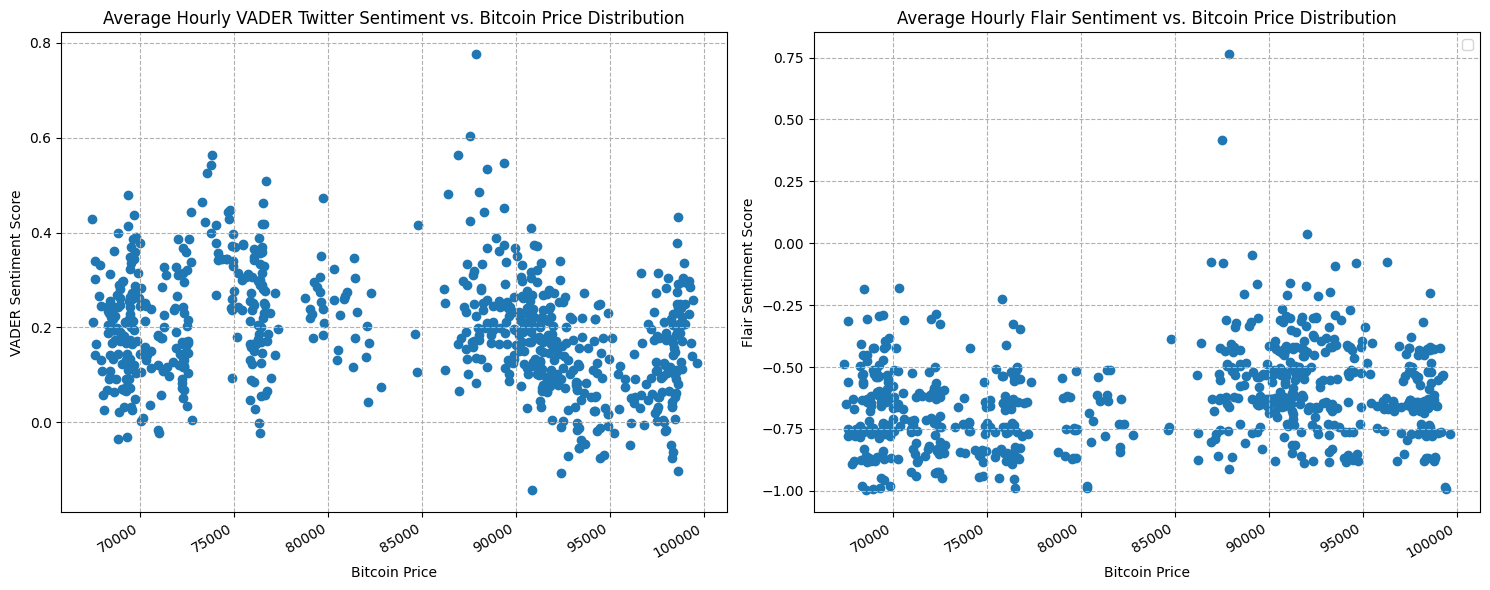

In [64]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound'], hr_btc_tw['fl_confidence'], 
  "Average Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Hourly Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

## Bitcoin Price Delta VS. Mean Sentiment Delta
### Hourly Mean & Median Data

In [66]:
hr_btc_tw['price_delta'] = hr_btc_tw['price'].diff()
hr_btc_tw['fl_confidence_delta'] = hr_btc_tw['fl_confidence'].diff()
hr_btc_tw['vd_compound_delta'] = hr_btc_tw['vd_compound'].diff()

In [67]:
hr_btc_tw = hr_btc_tw.dropna()

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


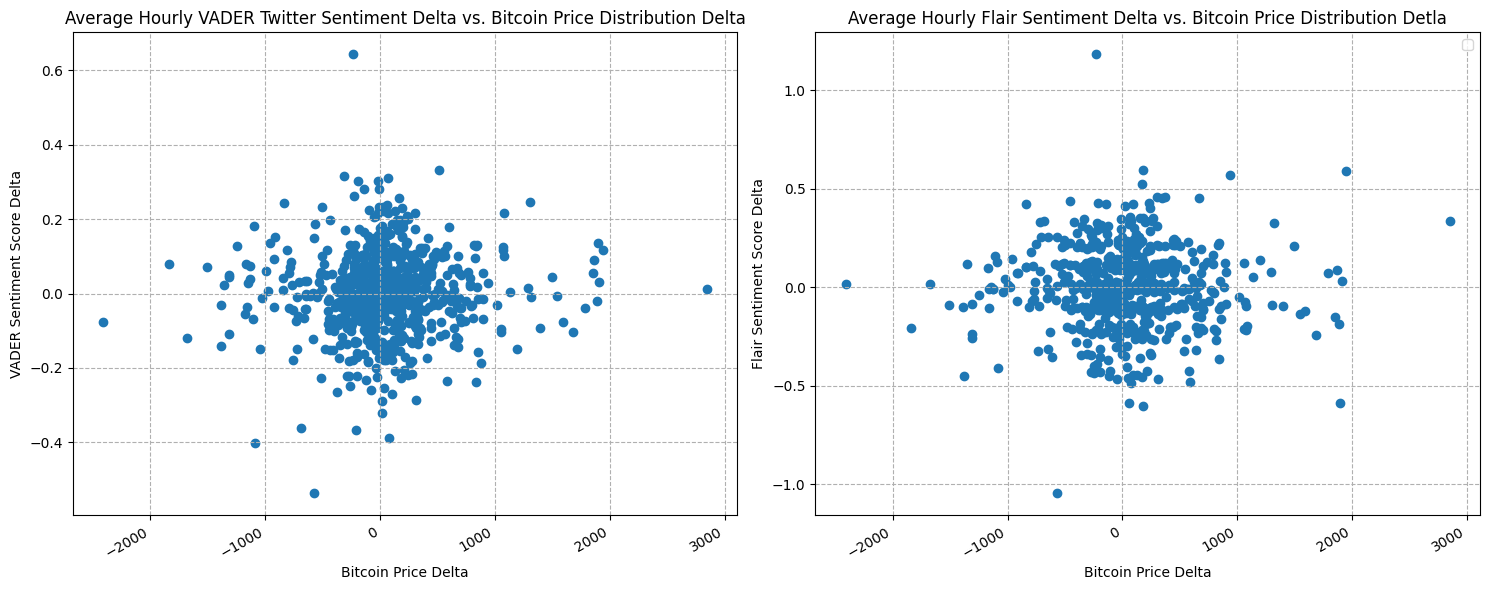

In [68]:
p.sentiment_price_scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound_delta'], hr_btc_tw['fl_confidence_delta'], 
  "Average Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Distribution Delta","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Hourly Flair Sentiment Delta vs. Bitcoin Price Distribution Detla", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

In [69]:
# Merge btc_data with tw_data using sentiment median values
df = pd.merge(hr_btc, v_hr_med, on='time')
hr_btc_tw = pd.merge(df, f_hr_med, on='time')

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,Signal_Line,MACD_Histogram,volatility,Doji,Hammer,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,59.863536,46.975034,0.318658,True,False,0.000,0.0,0.903,0.0000,-0.962878
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,75.051001,60.749859,0.295505,True,False,0.000,0.0,1.000,0.0000,-0.992461
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,96.279689,84.914751,0.294800,True,False,0.123,0.0,0.877,0.3182,-0.991899


/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


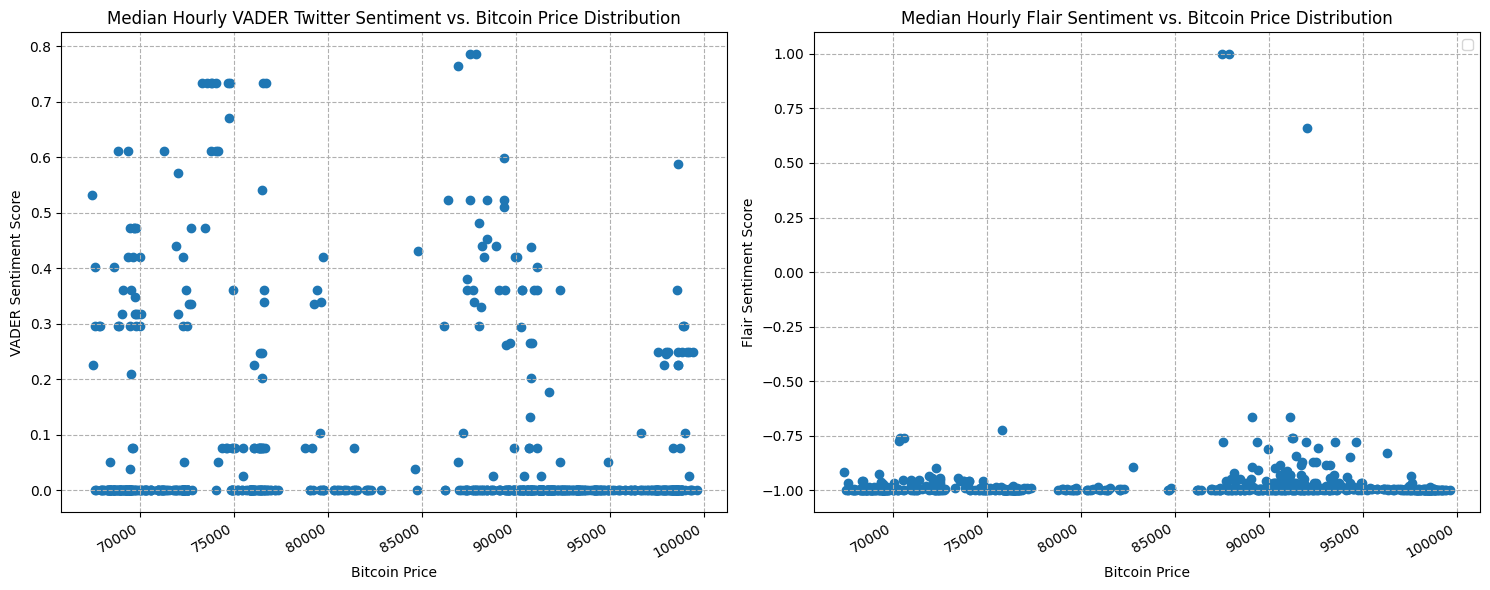

In [70]:
p.sentiment_price_scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound'], hr_btc_tw['fl_confidence'], 
  "Median Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Median Hourly Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

In [71]:
hr_btc_tw['price_delta'] = hr_btc_tw['price'].diff()
hr_btc_tw['volume_delta'] = hr_btc_tw['volume'].diff()
hr_btc_tw['fl_confidence_delta'] = hr_btc_tw['fl_confidence'].diff()
hr_btc_tw['vd_compound_delta'] = hr_btc_tw['vd_compound'].diff()

In [72]:
hr_btc_tw = hr_btc_tw.dropna()

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


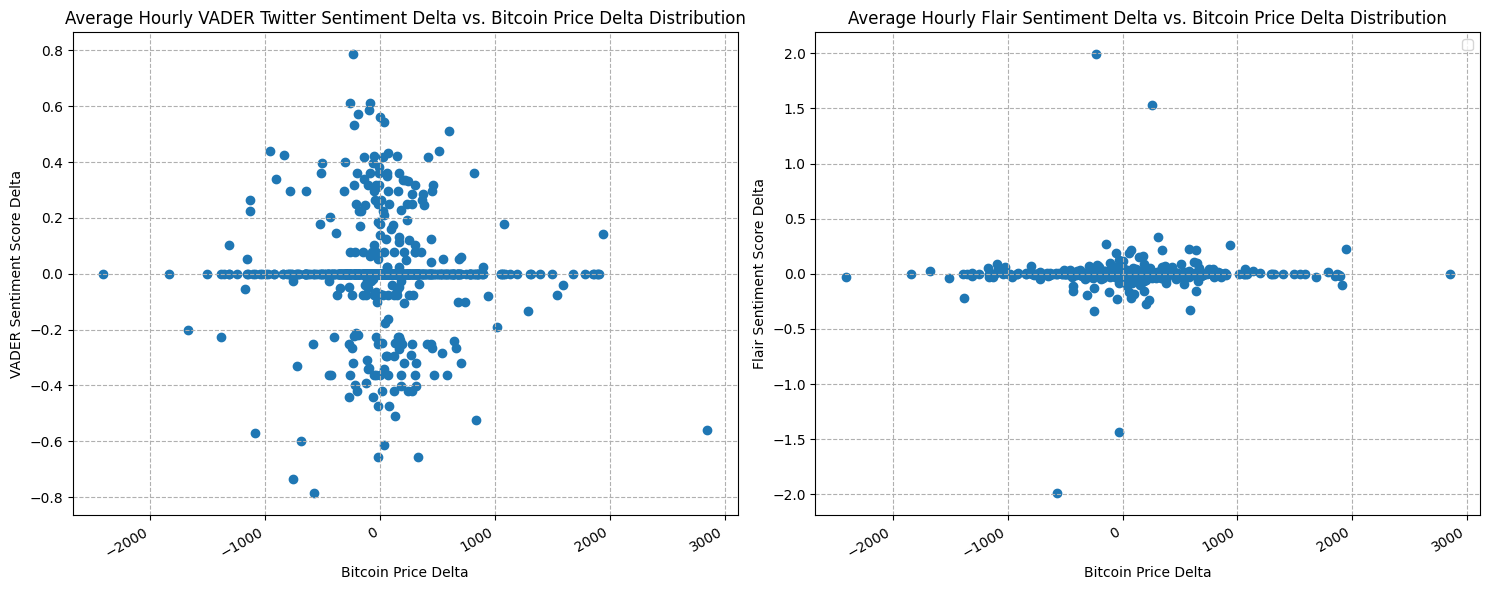

In [73]:
p.sentiment_price_scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound_delta'], hr_btc_tw['fl_confidence_delta'], 
  "Average Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Hourly Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

### Daily Mean and Median Data

In [74]:
day_btc_tw['price_delta'] = day_btc_tw['price'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

In [75]:
day_btc_tw = day_btc_tw.dropna()

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


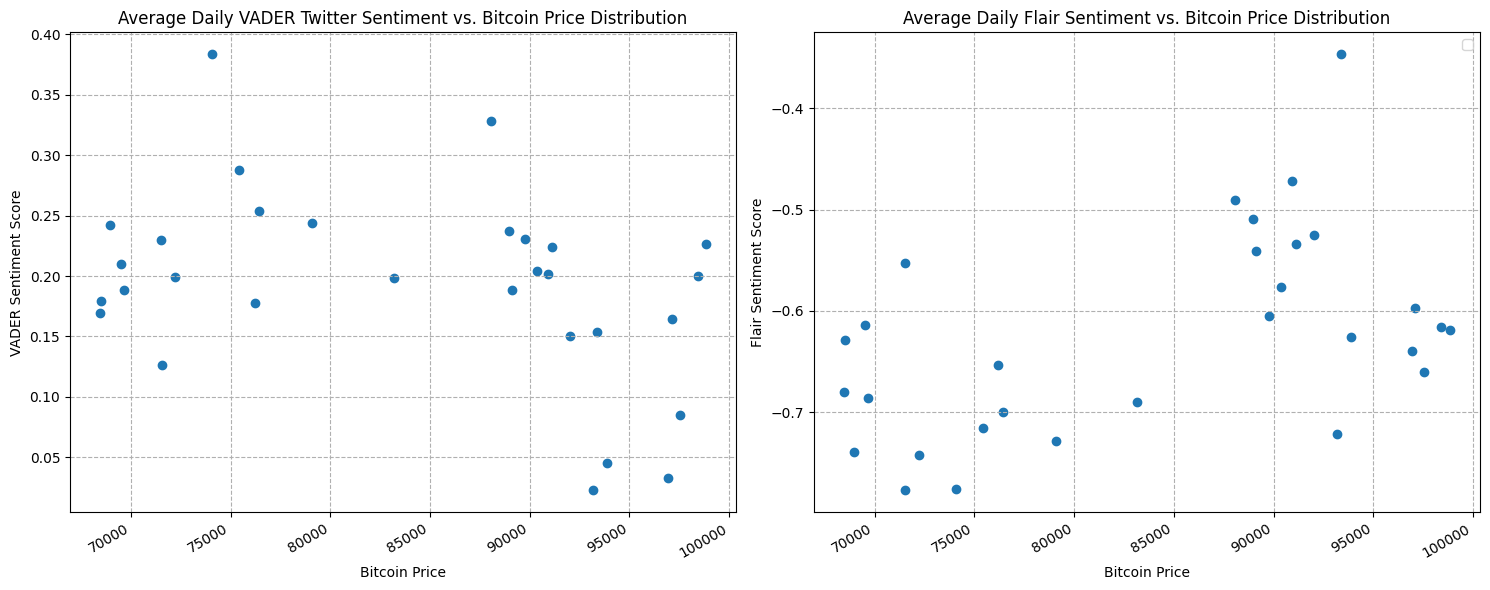

In [76]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['price'], day_btc_tw['vd_compound'], day_btc_tw['fl_confidence'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Daily Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

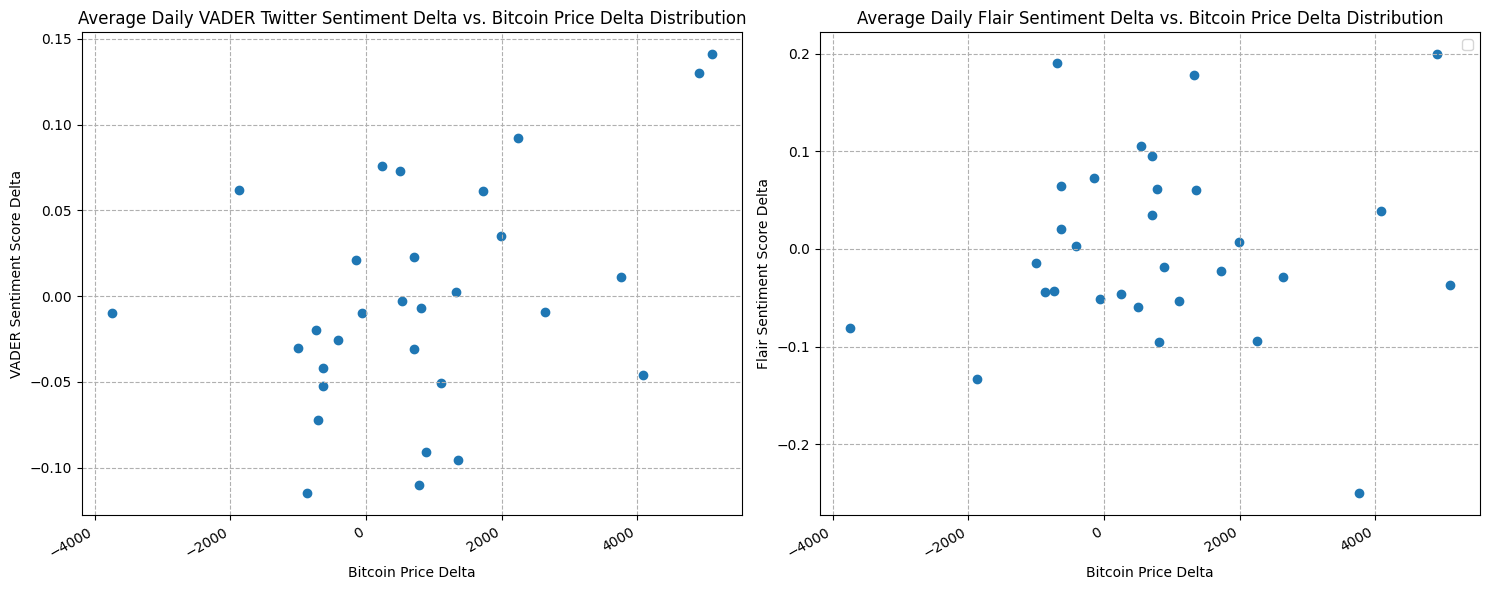

In [77]:
p.sentiment_price_scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_delta'], day_btc_tw['fl_confidence_delta'], 
  "Average Daily VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

In [80]:
# Merge btc_data with tw_data using sentiment median values
df = pd.merge(day_btc, v_day_med, on='time')
day_btc_tw = pd.merge(df, f_day_med, on='time')

day_btc_tw.head(3)

,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,Signal_Line,MACD_Histogram,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,2024-10-28,68720.00,70051.00,69289.377500,2.938971e+11,70288.00,67532.48,69101.052,69016.264981,80.582935,282.484373,156.474843,126.009530,0.0,0.0,0.889,0.0,-0.992180
1,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418,70980.873500,74.479081,713.869070,715.268277,-1.399207,0.0,0.0,0.889,0.0,-0.994748
2,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347,72298.577625,48.791275,137.377439,137.749967,-0.372528,0.0,0.0,1.000,0.0,-0.994748


In [81]:
day_btc_tw['price_delta'] = day_btc_tw['price'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

day_btc_tw = day_btc_tw.dropna()
day_btc_tw.head(3)


,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,...,Signal_Line,MACD_Histogram,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence,price_delta,fl_confidence_delta,vd_compound_delta
1,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418000,70980.873500,74.479081,...,715.268277,-1.399207,0.0,0.0,0.889,0.0,-0.994748,2247.922917,-0.002568,0.0
2,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,...,137.749967,-0.372528,0.0,0.0,1.000,0.0,-0.994748,703.530000,0.000000,0.0
3,2024-10-31,72364.69,70327.64,71540.485417,1.027684e+12,73060.00,69559.33,71730.912583,71912.237500,39.340133,...,-394.367773,-144.293662,0.0,0.0,1.000,0.0,-0.965998,-700.345000,0.028750,0.0


/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


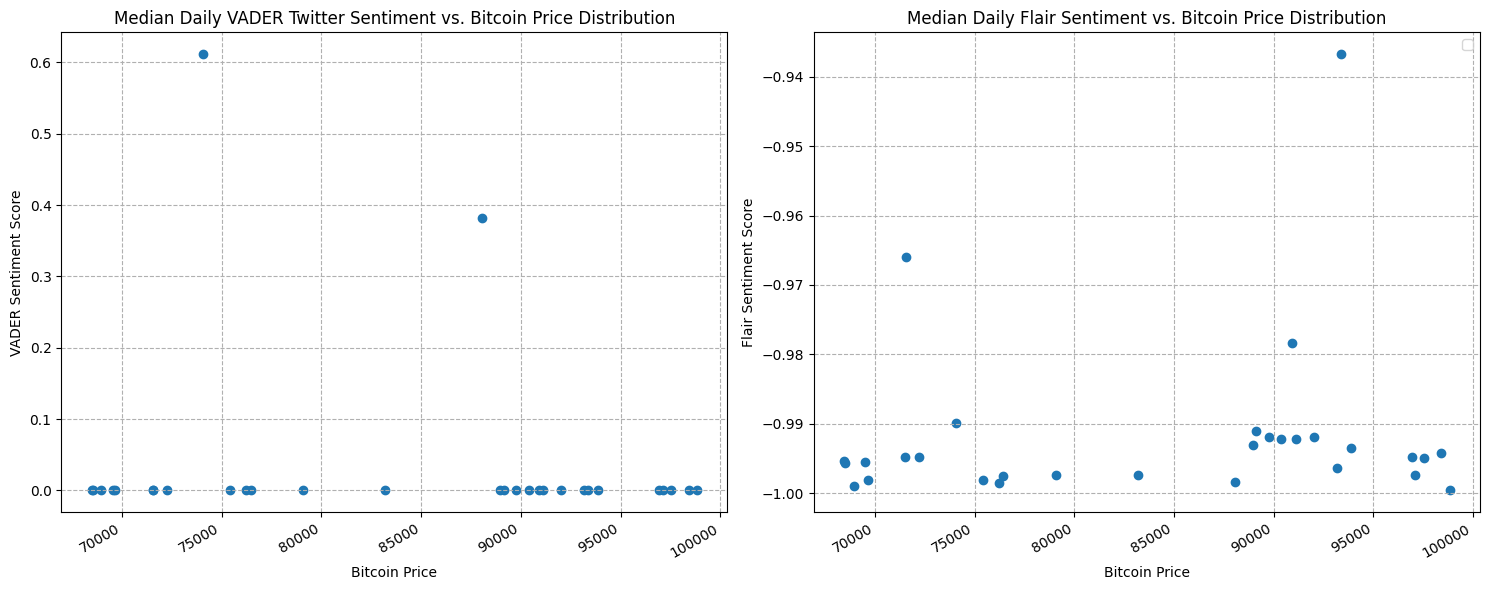

In [82]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['price'], day_btc_tw['vd_compound'], day_btc_tw['fl_confidence'], 
  "Median Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Median Daily Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

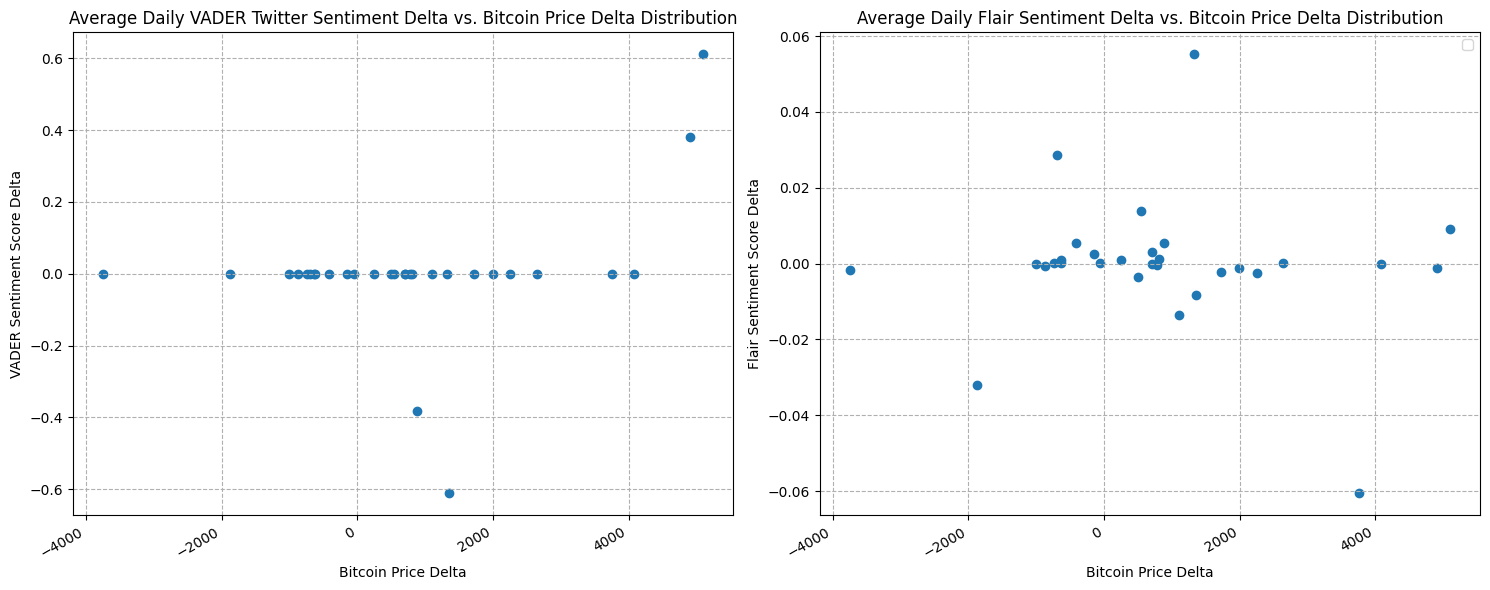

In [83]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_delta'], day_btc_tw['fl_confidence_delta'], 
  "Average Daily VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

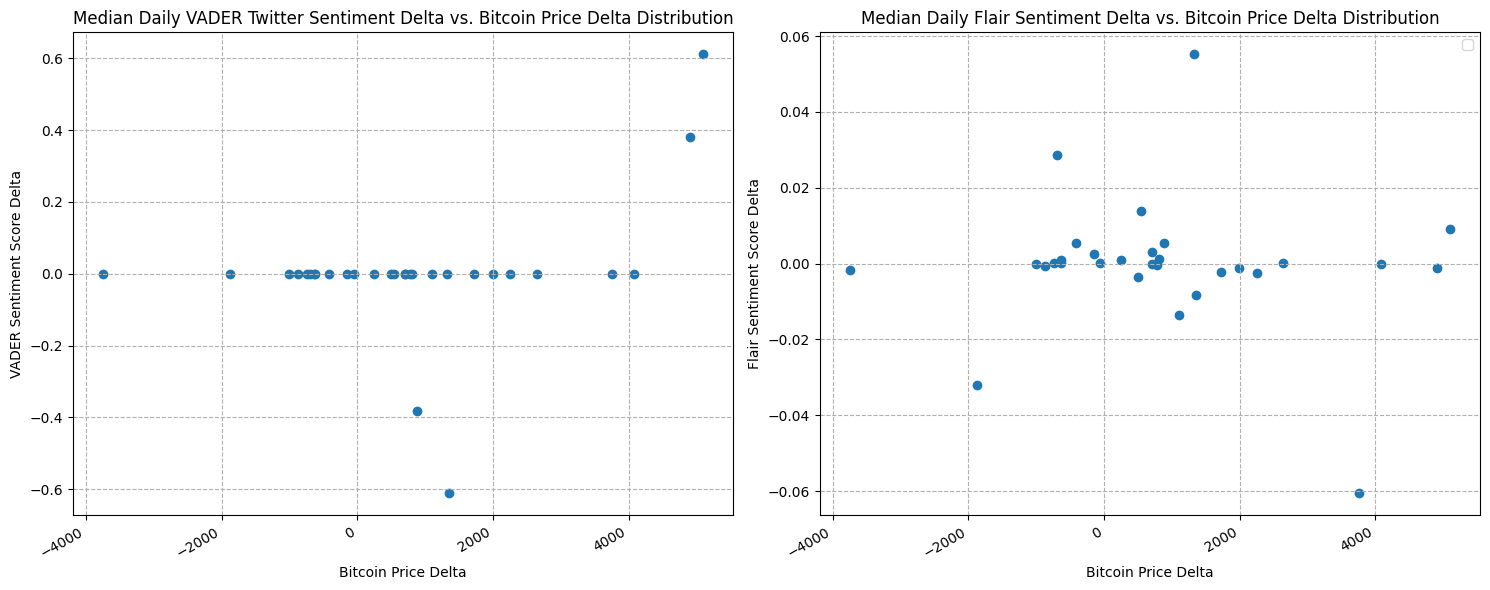

In [84]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_delta'], day_btc_tw['fl_confidence_delta'], 
  "Median Daily VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Median Daily Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

## Daily Max/Min Price Values VS. Daily Twitter Sentiment 

In [86]:
# Daily high 
btc_day_high = btc_data.groupby(
  btc_data['time'].dt.floor('d')
  )[['dayHigh']].max().reset_index()

btc_day_high.head(5)

,time,dayHigh
0,2024-10-28,70288.00
1,2024-10-29,73624.98
2,2024-10-30,73624.98
3,2024-10-31,73060.00
4,2024-11-01,72684.02


In [88]:
# Merge btc_data with tw_data using sentiment mean values
df = pd.merge(btc_day_high, v_day_mean, on='time')
day_btc_tw = pd.merge(df, f_day_mean, on='time')

day_btc_tw.head(3)

,time,dayHigh,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
0,2024-10-28,70288.00,0.084480,0.032990,0.882500,0.137509,-0.683241
1,2024-10-29,73624.98,0.087436,0.020728,0.891824,0.229950,-0.777407
2,2024-10-30,73624.98,0.078708,0.015728,0.905576,0.199071,-0.742708


In [89]:
day_btc_tw['dayHigh_delta'] = day_btc_tw['dayHigh'].diff()
day_btc_tw['fl_confidence_delta'] = day_btc_tw['fl_confidence'].diff()
day_btc_tw['vd_compound_delta'] = day_btc_tw['vd_compound'].diff()

day_btc_tw = day_btc_tw.dropna()
day_btc_tw.head(3)

,time,dayHigh,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence,dayHigh_delta,fl_confidence_delta,vd_compound_delta
1,2024-10-29,73624.98,0.087436,0.020728,0.891824,0.229950,-0.777407,3336.98,-0.094166,0.092441
2,2024-10-30,73624.98,0.078708,0.015728,0.905576,0.199071,-0.742708,0.00,0.034699,-0.030879
3,2024-10-31,73060.00,0.066368,0.030445,0.903187,0.126812,-0.552631,-564.98,0.190076,-0.072259


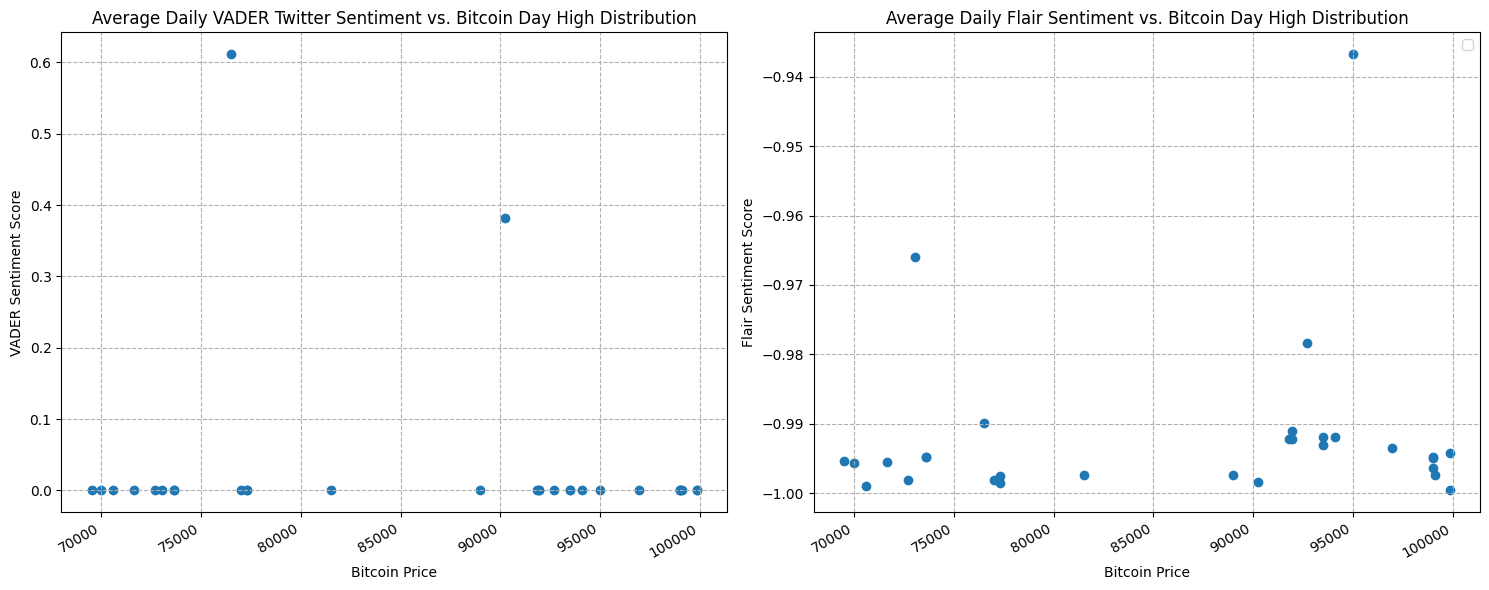

In [85]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['dayHigh'], day_btc_tw['vd_compound'], day_btc_tw['fl_confidence'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day High Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Daily Flair Sentiment vs. Bitcoin Day High Distribution", "Bitcoin Price", "Flair Sentiment Score")

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/plot.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.tight_layout()


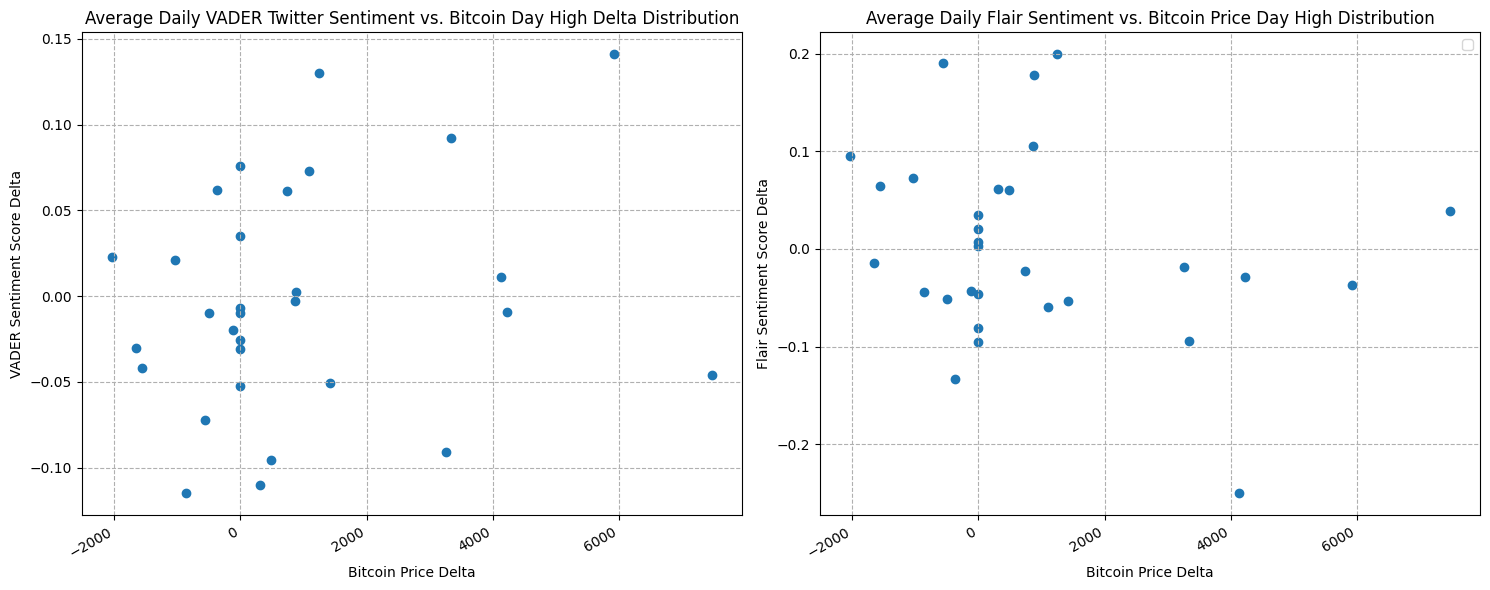

In [90]:
# Twitter sentiment vs. bitcoin price distribution 
p.sentiment_price_scatter(day_btc_tw['dayHigh_delta'], day_btc_tw['vd_compound_delta'], day_btc_tw['fl_confidence_delta'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day High Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment vs. Bitcoin Price Day High Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

## III Random Forest Prediction with daily data

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
# Load and preprocess data
df = pd.read_csv('day_btc_tw.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df.head(3)

,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,Signal_Line,MACD_Histogram,vd_positive,vd_negative,vd_neutral,vd_compound,fl_confidence
time,,,,,,,,,,,,,,,,,
2024-10-28,68720.00,70051.00,69289.377500,2.938971e+11,70288.00,67532.48,69101.052,69016.264981,80.582935,282.484373,156.474843,126.009530,0.084480,0.032990,0.882500,0.137509,-0.683241
2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418,70980.873500,74.479081,713.869070,715.268277,-1.399207,0.087436,0.020728,0.891824,0.229950,-0.777407
2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347,72298.577625,48.791275,137.377439,137.749967,-0.372528,0.078708,0.015728,0.905576,0.199071,-0.742708


In [94]:
# Feature sets
technical_features = ['SMA_5', 'SMA_10', 'RSI', 'MACD']
sentiment_features = ['vd_compound','fl_confidence']
price_features = ['price','volume', 'dayHigh', 'dayLow']

# Add volatility as a feature
df['volatility'] = df['price'].pct_change().rolling(window=10).std() * 100  # Rolling std dev of price changes

In [95]:
# Combine features and target
X = df[technical_features + sentiment_features + price_features + ['volatility']].copy()
y = df['price'].shift(-1)  # Predict next day's price

In [96]:
# Remove NaN values from both X and y
df_clean = pd.concat([X, y.rename('target_price')], axis=1).dropna()

# Ensure 'price' is a single Series
if isinstance(df_clean['price'], pd.DataFrame):
    df_clean['price'] = df_clean['price'].iloc[:, 0]  # Select the first column

df_clean.head(3)

,SMA_5,SMA_10,RSI,MACD,vd_compound,fl_confidence,price,volume,dayHigh,dayLow,volatility,target_price
time,,,,,,,,,,,,
2024-11-07,75404.088917,75308.007958,56.575507,505.973062,0.287876,-0.715537,75421.691250,2.177717e+12,76999.00,69371.32,2.829558,76204.048333
2024-11-08,76157.226583,76115.917958,55.628840,280.836052,0.177661,-0.653806,76204.048333,1.539208e+12,77312.18,74397.00,2.708730,76446.790417
2024-11-09,76457.327167,76486.552042,47.888550,36.774848,0.253561,-0.699882,76446.790417,1.164213e+12,77312.18,75608.00,2.708232,79090.067917


In [97]:
# Split data for machine learning
X = df_clean[technical_features + sentiment_features + price_features + ['volatility']]
y = df_clean['target_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [101]:
# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n2. Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


2. Model Performance:
RMSE: 5093.80
R² Score: 0.7727


In [102]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(3)

,feature,importance
8,dayHigh,0.167587
9,dayLow,0.164628
0,SMA_5,0.153565


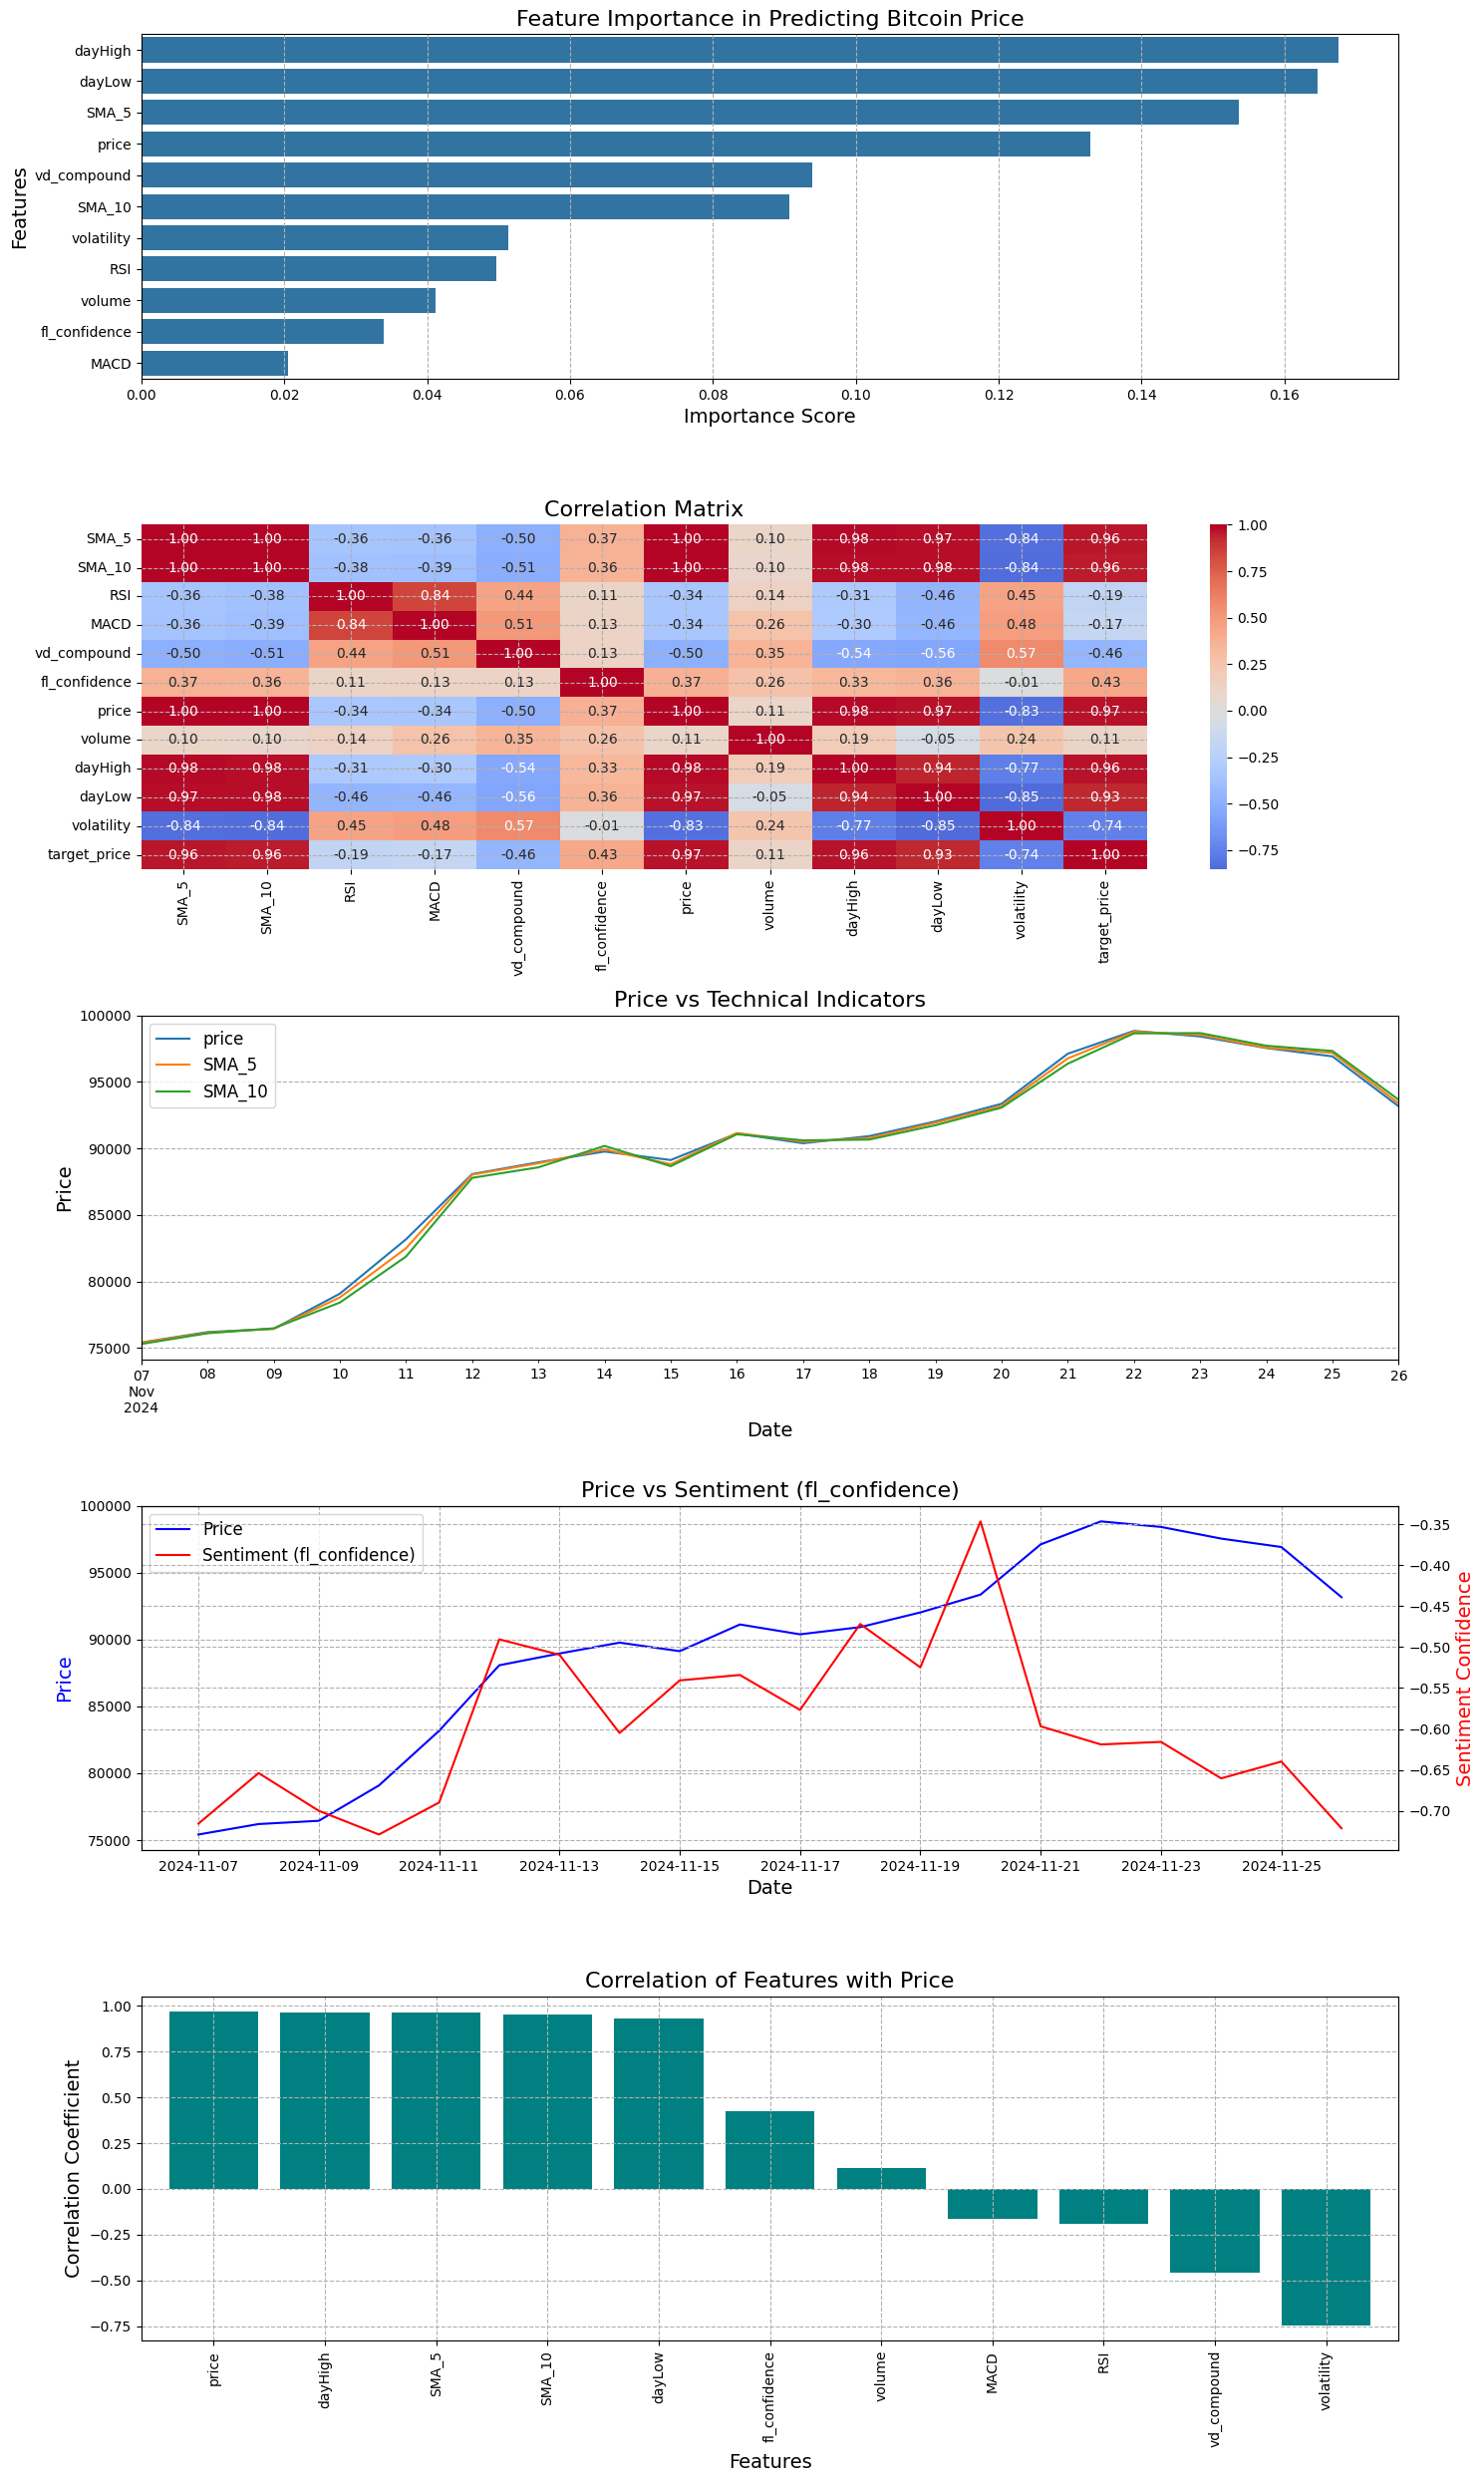

In [103]:
# Plotting
plt.figure(figsize=(15, 25))

# 1. Feature Importance Plot
plt.subplot(5, 1, 1)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Bitcoin Price', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()

# 2. Correlation Matrix Heatmap
correlation_matrix = df_clean.corr()
plt.subplot(5, 1, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()

# 3. Price vs Technical Indicators
plt.subplot(5, 1, 3)
df_clean[['price', 'SMA_5', 'SMA_10']].plot(ax=plt.gca())
plt.title('Price vs Technical Indicators', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# 4. Sentiment (fl_confidence) vs Price
plt.subplot(5, 1, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(df_clean.index, df_clean['price'], color='blue', label='Price')
ax2.plot(df_clean.index, df_clean['fl_confidence'], color='red', label='Sentiment (fl_confidence)')
plt.title('Price vs Sentiment (fl_confidence)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Price', fontsize=14, color='blue')
ax2.set_ylabel('Sentiment Confidence', fontsize=14, color='red')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
plt.tight_layout()

# 5. Correlation of Features with Price
plt.subplot(5, 1, 5)
price_correlations = correlation_matrix['target_price'].sort_values(ascending=False)
price_correlations.drop('target_price').plot(kind='bar', color='teal', width=0.8)
plt.title('Correlation of Features with Price', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.tight_layout()

plt.show()

In [104]:
# Print Results
print("\n1. Feature Group Importance:")
tech_importance = feature_importance[feature_importance['feature'].isin(technical_features)]['importance'].sum()
sentiment_importance = feature_importance[feature_importance['feature'].isin(sentiment_features)]['importance'].sum()
price_importance = feature_importance[feature_importance['feature'].isin(price_features + ['volatility'])]['importance'].sum()
print(f"Technical Indicators: {tech_importance:.4f}")
print(f"Sentiment Features: {sentiment_importance:.4f}")
print(f"Price Features: {price_importance:.4f}")

print("\n2. Correlation with Price:")
print(price_correlations)



1. Feature Group Importance:
Technical Indicators: 0.3146
Sentiment Features: 0.1278
Price Features: 0.5576

2. Correlation with Price:
target_price     1.000000
price            0.966954
dayHigh          0.963908
SMA_5            0.961024
SMA_10           0.955215
dayLow           0.932032
fl_confidence    0.426133
volume           0.112652
MACD            -0.165116
RSI             -0.188649
vd_compound     -0.456158
volatility      -0.743715
Name: target_price, dtype: float64
